In [1]:
import warnings
warnings.filterwarnings('default')

In [6]:
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

import lvm_read
import pyFRF
import pyidi
import pyEMA

import tqdm
import cv2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, find_peaks
import tqdm


%matplotlib inline

In [7]:
# Load Video
def loadVideo(video_path):
    image_sequence = []
    
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    
    while video.isOpened():
        ret, frame = video.read()

        if ret is False:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        image_sequence.append(frame[:, :])

    video.release()

    return np.asarray(image_sequence), fps, height, width

In [8]:
images, fps, height, width = loadVideo('data/video.mp4')


In [9]:
images.shape

(448, 854, 480)

In [10]:
video = pyidi.pyIDI(images, fps=fps)
height = images.shape[1]
width = images.shape[-1]
nFrames = images.shape[0]

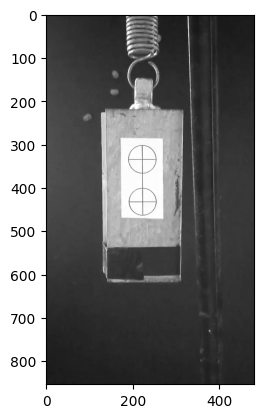

In [11]:
sequential_image_nr = 175
plt.imshow(video.mraw[sequential_image_nr], cmap='gray')
plt.grid(False)

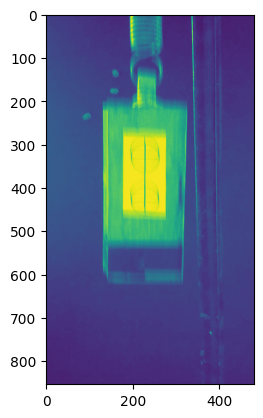

In [12]:
reference_image = np.average(video.mraw[:3], axis=0)
plt.imshow(reference_image)

In [13]:
grad0, grad1 = np.gradient(reference_image)

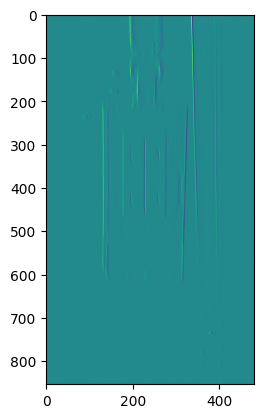

In [14]:
plt.imshow(grad1)

In [15]:
border = 20
border_h = 12
n = 2
N = 16
w = np.arange(border, reference_image.shape[1]-border, np.abs(border - reference_image.shape[1]-border)//N)
h = np.argsort(np.abs(grad0[border_h:-border_h, w]), axis=0)[-n:, :].T + border_h
inds = np.column_stack((h.flatten(), w.repeat(n)))

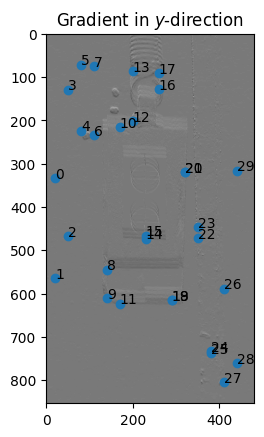

In [16]:
fig, ax = plt.subplots()
ax.imshow(grad0, cmap='gray')
ax.scatter(inds[:, 1], inds[:, 0])
for i in range(len(inds)):
    ax.annotate(str(i), (inds[:, 1][i], inds[:, 0][i]))
ax.grid(False)
ax.set_title('Gradient in $y$-direction');

In [17]:
video.set_points(points=inds) # setting points for analysis

In [18]:
video.set_method(method='sof',
                mean_n_neighbours=n)

In [19]:
displacements = video.get_displacements() * 8e-5

100%|████████████████████████████████████████████████████████████| 448/448 [00:01<00:00, 275.92it/s]


Averaging...
Finished!


/home/maheswaran/miniconda3/envs/myenv/lib/python3.7/site-packages/pyidi/methods/_simplified_optical_flow.py:138: UserWarning: Displacement larger than 0.5 pixel
  warnings.warn('Displacement larger than 0.5 pixel')


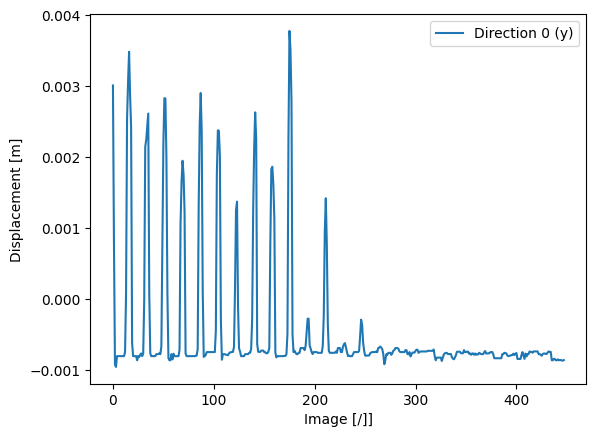

In [20]:
location = 9
fig, ax = plt.subplots()
ax.plot(displacements[location, :, 0], label='Direction 0 (y)');
ax.set_xlabel('Image [/]]')
ax.set_ylabel('Displacement [m]')
plt.legend()

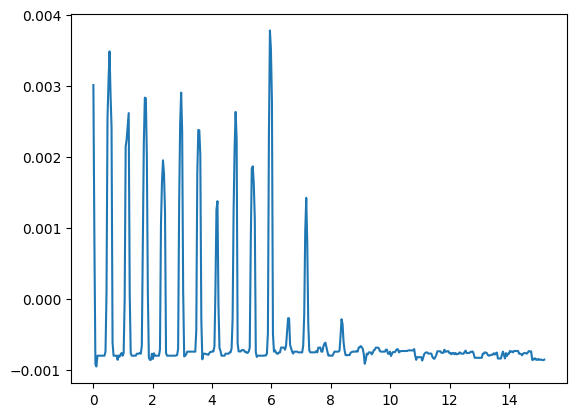

In [21]:
t = np.linspace(0, nFrames/fps, nFrames)
plt.plot(t, displacements[location, :, 0])

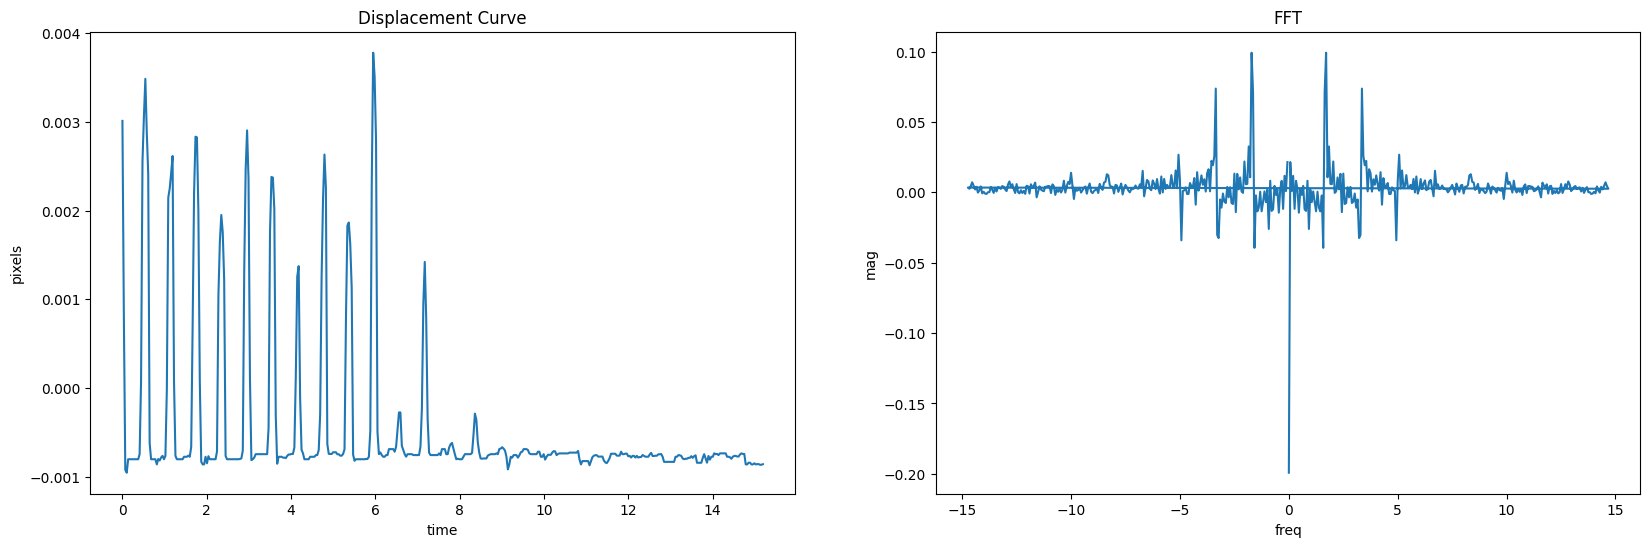

In [22]:
freq = np.fft.fftfreq(nFrames, 1/fps)
fft = np.fft.fft(displacements[location, :, 0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].set_title('Displacement Curve')
ax[0].set(xlabel='time', ylabel='pixels')
# ax[0].xlabel('Time')
# ax[0].ylabel('Pixels')
ax[0].plot(t, displacements[location, :, 0])
ax[1].set_title('FFT')
ax[1].set(xlabel='freq', ylabel='mag')
# ax[1].xlabel('Freq')
# ax[1].ylabel('Mag')
ax[1].plot(freq, fft)

plt.show()


In [64]:
predicted_freq = freq[np.argmax(np.real(fft))]

1.7112991071428572

In [69]:
# Actual value of freq 
m = 1.869
k = 221.24

f = np.sqrt(k/m) * (1 / (2 * np.pi))
practial_freq = f
practial_freq

1.7315989183243492

# Predicted Frequency is 1.71Hz and Practical Frequency is 1.73Hz

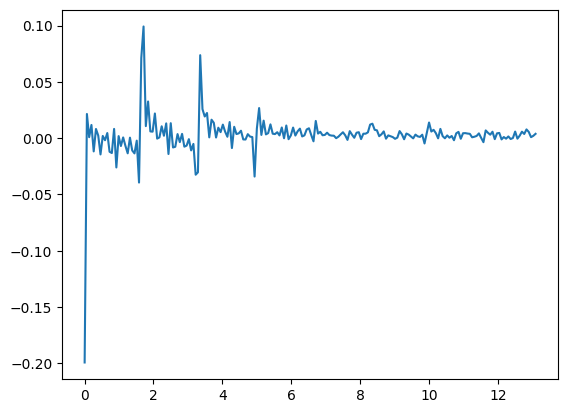

In [20]:
plt.plot(freq[:200], fft[:200])